<a href="https://colab.research.google.com/github/Priya9112/Time-Series-Analysis-Final-Project/blob/main/02_LSTM_Transformer_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 """
Notebook 2 — LSTM, Transformer, Multi-step Forecasting, Hybrid Ensemble

This notebook covers Weeks 3 and 4 of the project pipeline:
1. Prepare scaled volatility sequences for neural network models
2. Build and train LSTM models:
     • 30-day rolling input windows
     • Next-day and multi-step forecasting (t+1, t+5, t+10, t+21)
     • Evaluate using RMSE and directional accuracy
3. Build and train Transformer encoder models for volatility forecasting
4. Compare classical vs. deep learning predictions (visual + quantitative)
5. Construct a Hybrid Weighted Ensemble (ARIMA + GARCH + LSTM + Transformer):
     • Use non-negative regression to learn optimal weights
     • Produce final combined volatility forecasts
6. Generate model comparison tables, performance metrics, and final plots

This notebook completes the modeling pipeline and produces the results
used in the final report and presentation.
"""

WEEK 3 — Deep Learning for Volatility Forecasting (LSTM)

In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use("seaborn-v0_8")
pd.options.display.float_format = '{:.6f}'.format

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [2]:
# Cell 2: Sequence generator
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)


In [3]:
# Cell 3: LSTM architecture
def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(
        optimizer='adam',
        loss='mse'
    )
    return model



================ AAPL =================


/tmp/ipython-input-1356759786.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


AAPL LSTM RMSE: 0.001904


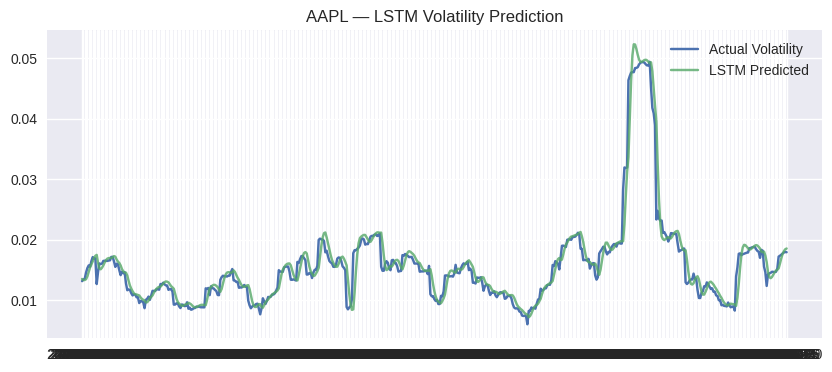


================ TSLA =================


/tmp/ipython-input-1356759786.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TSLA LSTM RMSE: 0.003380


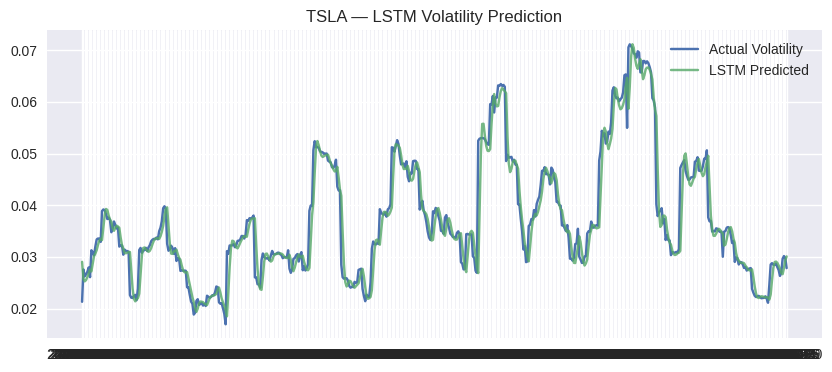


================ SPY =================


/tmp/ipython-input-1356759786.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


SPY LSTM RMSE: 0.001197


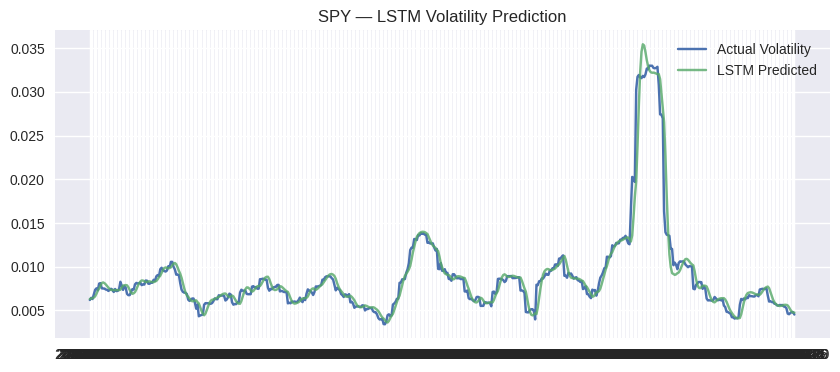

In [4]:
# Cell 4: Train LSTM for AAPL, TSLA, SPY

tickers = ['AAPL', 'TSLA', 'SPY']
SEQ_LEN = 30
EPOCHS = 25
BATCH_SIZE = 32

results = {}

for t in tickers:
    print(f"\n================ {t} =================")

    # Load data
    df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
                     index_col=0, parse_dates=True)

    series = df[['Volatility_21']].dropna()

    # Scale data
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series)

    # Create sequences
    X, y = create_sequences(scaled, SEQ_LEN)

    # Train-test split (80/20, NO SHUFFLE)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build model
    model = build_lstm((SEQ_LEN, 1))

    # Early stopping
    es = EarlyStopping(patience=5, restore_best_weights=True)

    # Train
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es],
        verbose=0
    )

    # Predict
    preds = model.predict(X_test, verbose=0)

    # Inverse scaling
    preds_inv = scaler.inverse_transform(preds)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    print(f"{t} LSTM RMSE: {rmse:.6f}")

    results[t] = {
        "rmse": rmse,
        "y_true": y_test_inv.flatten(),
        "y_pred": preds_inv.flatten(),
        "index": df.index[-len(y_test_inv):]
    }

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(results[t]["index"], results[t]["y_true"], label="Actual Volatility")
    plt.plot(results[t]["index"], results[t]["y_pred"], label="LSTM Predicted", alpha=0.8)
    plt.title(f"{t} — LSTM Volatility Prediction")
    plt.legend()
    plt.show()


In [5]:
# Cell 5: LSTM results summary
lstm_summary = pd.DataFrame([
    {"Ticker": t, "LSTM_RMSE": results[t]["rmse"]}
    for t in results
])

display(lstm_summary)


,Ticker,LSTM_RMSE
0,AAPL,0.001904
1,TSLA,0.003380
2,SPY,0.001197


In [6]:
# Cell 6: Multi-step sequence creator
def create_multistep_sequences(data, seq_len=30, horizon=5):
    X, y = [], []
    for i in range(seq_len, len(data) - horizon + 1):
        X.append(data[i-seq_len:i])
        y.append(data[i + horizon - 1])  # target at t + horizon
    return np.array(X), np.array(y)



================ AAPL ================

--- Horizon: t+5 ---


/tmp/ipython-input-918388917.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


AAPL LSTM RMSE (t+5): 0.004115


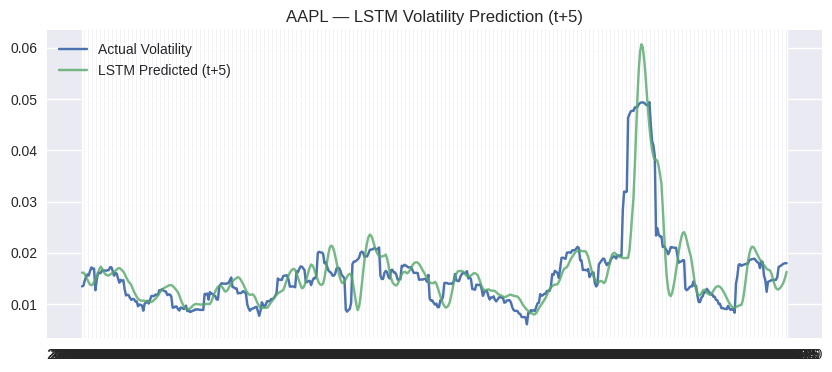


--- Horizon: t+10 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


AAPL LSTM RMSE (t+10): 0.005548


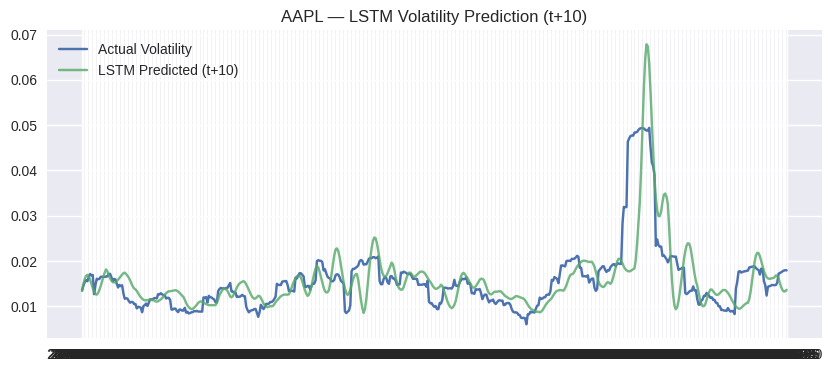


--- Horizon: t+21 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


AAPL LSTM RMSE (t+21): 0.007288


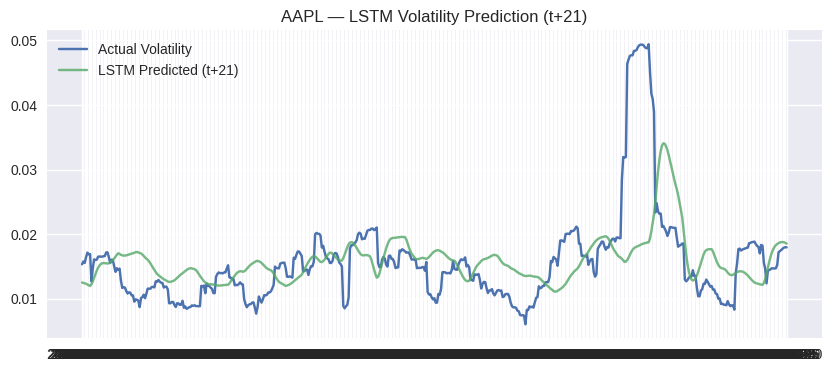


================ TSLA ================

--- Horizon: t+5 ---


/tmp/ipython-input-918388917.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TSLA LSTM RMSE (t+5): 0.006493


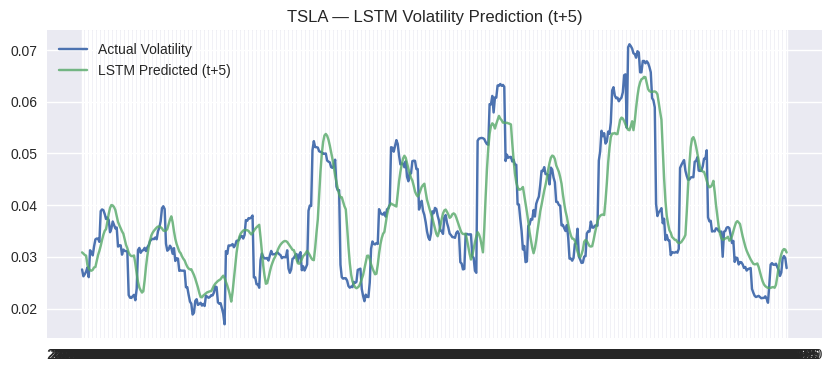


--- Horizon: t+10 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TSLA LSTM RMSE (t+10): 0.008955


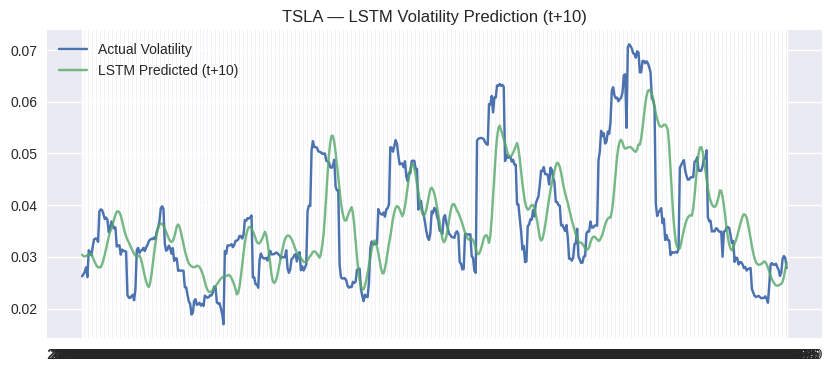


--- Horizon: t+21 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TSLA LSTM RMSE (t+21): 0.012413


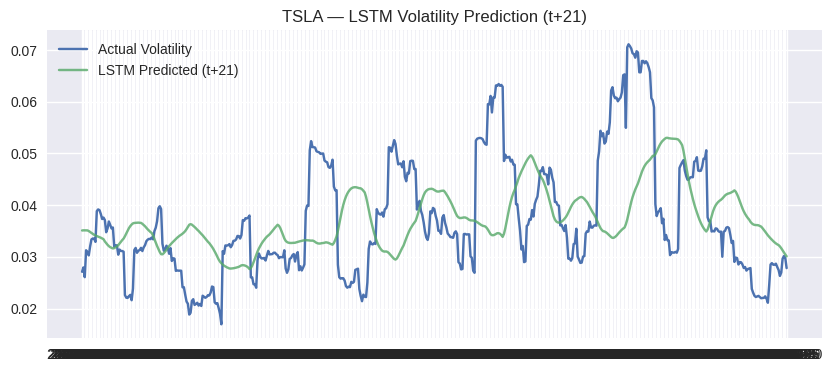


================ SPY ================

--- Horizon: t+5 ---


/tmp/ipython-input-918388917.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


SPY LSTM RMSE (t+5): 0.002732


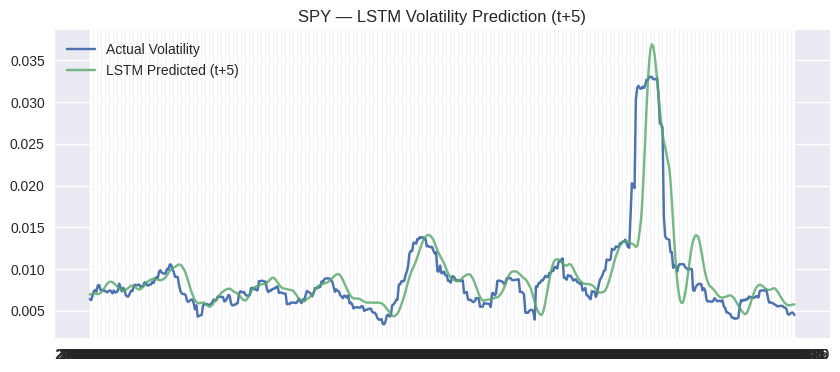


--- Horizon: t+10 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


SPY LSTM RMSE (t+10): 0.003687


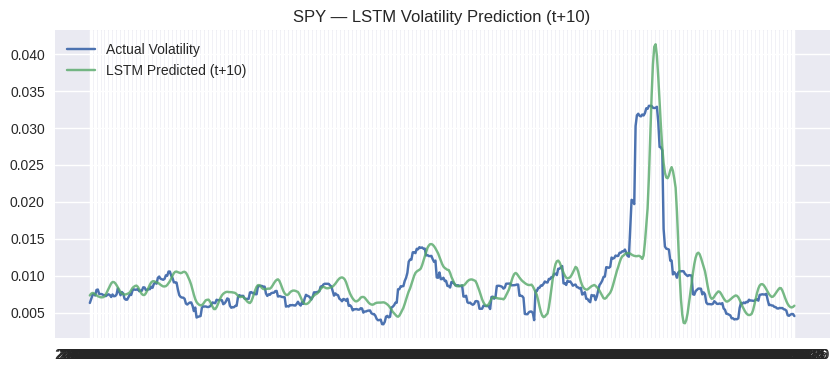


--- Horizon: t+21 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


SPY LSTM RMSE (t+21): 0.005097


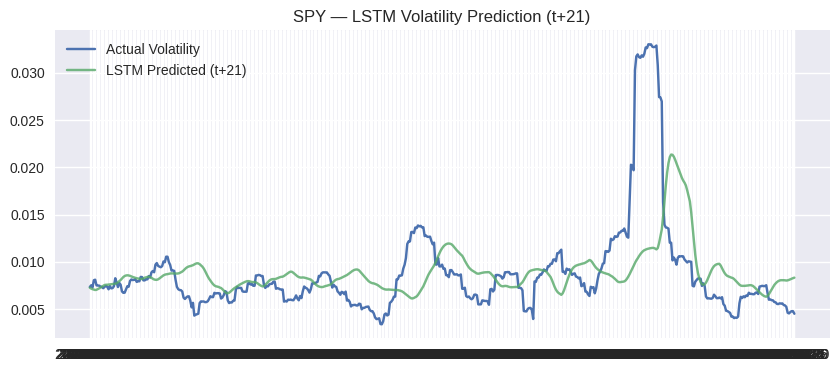

In [7]:
# Cell 7: Multi-step forecasting (t+5, t+10, t+21)

horizons = [5, 10, 21]   # 1 week, 2 weeks, 1 month
multistep_results = {}

for t in tickers:
    print(f"\n================ {t} ================")
    multistep_results[t] = {}

    df = pd.read_csv(
        f"/content/drive/MyDrive/TSA/{t}_clean.csv",
        index_col=0, parse_dates=True
    )

    series = df[['Volatility_21']].dropna()



    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series)

    for h in horizons:
        print(f"\n--- Horizon: t+{h} ---")

        X, y = create_multistep_sequences(scaled, SEQ_LEN, horizon=h)

        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        model = build_lstm((SEQ_LEN, 1))
        es = EarlyStopping(patience=5, restore_best_weights=True)

        model.fit(
            X_train, y_train,
            validation_split=0.1,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[es],
            verbose=0
        )

        preds = model.predict(X_test, verbose=0)

        preds_inv = scaler.inverse_transform(preds)
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

        # RMSE
        rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
        print(f"{t} LSTM RMSE (t+{h}): {rmse:.6f}")

        multistep_results[t][h] = {
            "rmse": rmse,
            "y_true": y_test_inv.flatten(),
            "y_pred": preds_inv.flatten(),
            "index": df.index[-len(y_test_inv):]
        }

        # Plot
        plt.figure(figsize=(10,4))
        plt.plot(multistep_results[t][h]["index"], multistep_results[t][h]["y_true"], label="Actual Volatility")
        plt.plot(multistep_results[t][h]["index"], multistep_results[t][h]["y_pred"], label=f"LSTM Predicted (t+{h})", alpha=0.8)
        plt.title(f"{t} — LSTM Volatility Prediction (t+{h})")
        plt.legend()
        plt.show()

In [8]:
# Cell 9: RMSE summary table

rmse_rows = []

for t in multistep_results:
    for h in multistep_results[t]:
        rmse_rows.append({
            "Ticker": t,
            "Horizon": f"t+{h}",
            "LSTM_RMSE": multistep_results[t][h]["rmse"]
        })

rmse_df = pd.DataFrame(rmse_rows)
display(rmse_df)


,Ticker,Horizon,LSTM_RMSE
0,AAPL,t+5,0.004115
1,AAPL,t+10,0.005548
2,AAPL,t+21,0.007288
3,TSLA,t+5,0.006493
4,TSLA,t+10,0.008955
5,TSLA,t+21,0.012413
6,SPY,t+5,0.002732
7,SPY,t+10,0.003687
8,SPY,t+21,0.005097


In [9]:
# Cell 8: Directional accuracy (t+1 + multi-step)

directional_results = []

# ---- t+1 (from Week 3 LSTM results) ----
for t in results:
    y_true = results[t]["y_true"]
    y_pred = results[t]["y_pred"]

    direction_true = np.diff(y_true) > 0
    direction_pred = np.diff(y_pred) > 0

    directional_acc = np.mean(direction_true == direction_pred)

    directional_results.append({
        "Ticker": t,
        "Horizon": "t+1",
        "Directional_Accuracy": directional_acc
    })


# ---- Multi-step (t+5, t+10, t+21) ----
for t in multistep_results:
    for h in multistep_results[t]:
        y_true = multistep_results[t][h]["y_true"]
        y_pred = multistep_results[t][h]["y_pred"]

        direction_true = np.diff(y_true) > 0
        direction_pred = np.diff(y_pred) > 0

        directional_acc = np.mean(direction_true == direction_pred)

        directional_results.append({
            "Ticker": t,
            "Horizon": f"t+{h}",
            "Directional_Accuracy": directional_acc
        })

directional_df = pd.DataFrame(directional_results)
display(directional_df.sort_values(["Ticker", "Horizon"]))


,Ticker,Horizon,Directional_Accuracy
0,AAPL,t+1,0.507547
4,AAPL,t+10,0.520833
5,AAPL,t+21,0.484791
3,AAPL,t+5,0.551985
2,SPY,t+1,0.518868
10,SPY,t+10,0.511364
11,SPY,t+21,0.420152
9,SPY,t+5,0.516068
1,TSLA,t+1,0.549057
7,TSLA,t+10,0.471591


In [10]:
# Rebuild LSTM results (to Week 3 reuse)

lstm_results = {}

for t in ['AAPL','TSLA','SPY']:

    df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
                     index_col=0, parse_dates=True)
    series = df[['Volatility_21']].dropna()

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series)

    X, y = create_sequences(scaled, seq_len=30)

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = build_lstm((30,1))
    model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=0)

    preds = model.predict(X_test, verbose=0)

    lstm_results[t] = {
        "y_pred": scaler.inverse_transform(preds).flatten(),
        "y_true": scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
    }

print("LSTM results rebuilt")


/tmp/ipython-input-3447381689.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-3447381689.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer

LSTM results rebuilt


WEEK 4A — Transformer for Volatility Forecasting

In [11]:
# Cell 1: Transformer imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, Dropout,
    MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use("seaborn-v0_8")
pd.options.display.float_format = '{:.6f}'.format

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [12]:
# Cell 2: Sequence generator
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)


In [13]:
# Cell 3: Transformer model builder
def build_transformer(seq_len, n_features=1, head_size=32, num_heads=2, ff_dim=64):

    inputs = Input(shape=(seq_len, n_features))

    # Self-attention
    x = MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=0.1
    )(inputs, inputs)

    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(0.1)(x)

    # Feed-forward block
    x = Dense(ff_dim, activation="relu")(x)
    x = Dense(n_features)(x)

    # Global pooling
    x = GlobalAveragePooling1D()(x)

    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")

    return model



================ AAPL =================


/tmp/ipython-input-1519379004.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",


AAPL Transformer RMSE: 0.007581


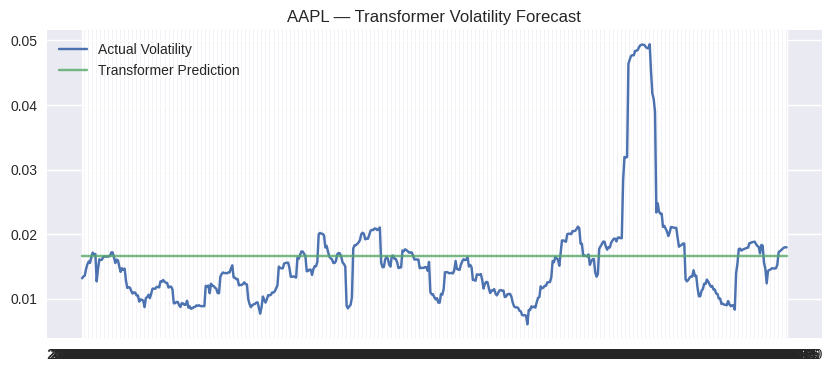


================ TSLA =================


/tmp/ipython-input-1519379004.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",


TSLA Transformer RMSE: 0.012742


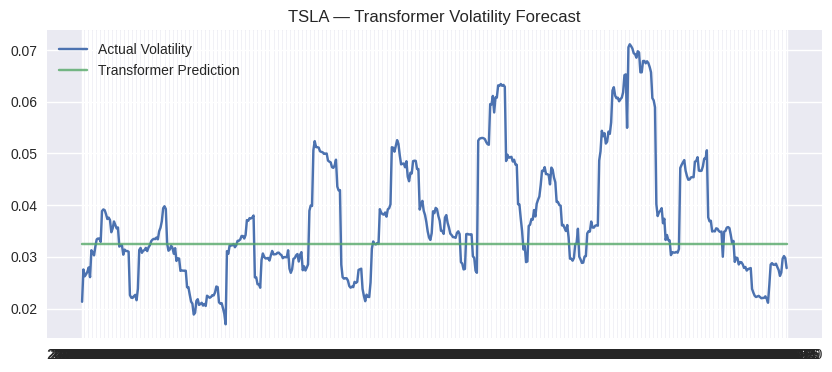


================ SPY =================


/tmp/ipython-input-1519379004.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",


SPY Transformer RMSE: 0.005310


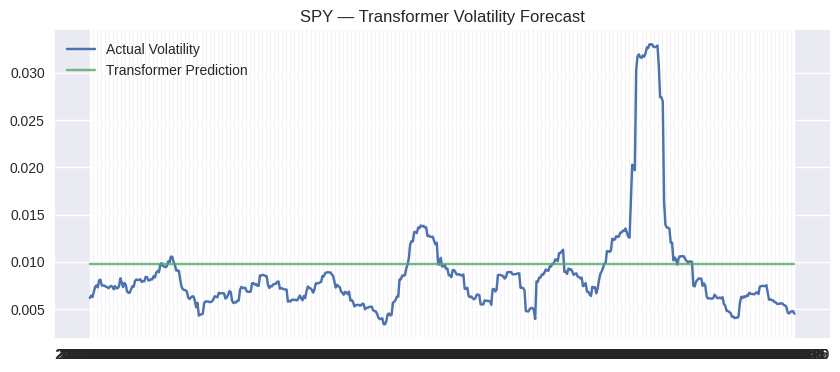

In [14]:
# Cell 4: Train Transformer for AAPL, TSLA, SPY

tickers = ['AAPL', 'TSLA', 'SPY']
SEQ_LEN = 30
EPOCHS = 25
BATCH_SIZE = 32

transformer_results = {}

for t in tickers:
    print(f"\n================ {t} =================")

    # Load data
    df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
                     index_col=0, parse_dates=True)

    series = df[['Volatility_21']].dropna()

    # Scale
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series)

    # Sequences
    X, y = create_sequences(scaled, SEQ_LEN)

    # Train-test split
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build Transformer
    model = build_transformer(SEQ_LEN)

    es = EarlyStopping(patience=5, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es],
        verbose=0
    )

    # Predict
    preds = model.predict(X_test, verbose=0)

    # Inverse scale
    preds_inv = scaler.inverse_transform(preds)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    print(f"{t} Transformer RMSE: {rmse:.6f}")

    transformer_results[t] = {
        "rmse": rmse,
        "y_true": y_test_inv.flatten(),
        "y_pred": preds_inv.flatten(),
        "index": df.index[-len(y_test_inv):]
    }

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(transformer_results[t]["index"],
             transformer_results[t]["y_true"], label="Actual Volatility")
    plt.plot(transformer_results[t]["index"],
             transformer_results[t]["y_pred"], label="Transformer Prediction", alpha=0.8)
    plt.title(f"{t} — Transformer Volatility Forecast")
    plt.legend()
    plt.show()


In [15]:
# Cell 5: Transformer RMSE summary
transformer_summary = pd.DataFrame([
    {"Ticker": t, "Transformer_RMSE": transformer_results[t]["rmse"]}
    for t in transformer_results
])

display(transformer_summary)


,Ticker,Transformer_RMSE
0,AAPL,0.007581
1,TSLA,0.012742
2,SPY,0.005310


In [ ]:
import pickle

with open("/content/drive/MyDrive/TSA/lstm_results.pkl", "wb") as f:
    pickle.dump(lstm_results, f)

with open("/content/drive/MyDrive/TSA/transformer_results.pkl", "wb") as f:
    pickle.dump(transformer_results, f)


WEEK 4B — Hybrid Integration

In [16]:
# Cell 1: Imports for Hybrid Model
!pip install arch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from arch import arch_model

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use("seaborn-v0_8")
pd.options.display.float_format = '{:.6f}'.format

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 52.6 MB/s eta 0:00:00


In [17]:
# Cell 2: Sequence creator
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)



================ AAPL ================


/tmp/ipython-input-2120127031.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",


AAPL Hybrid RMSE: 0.381035


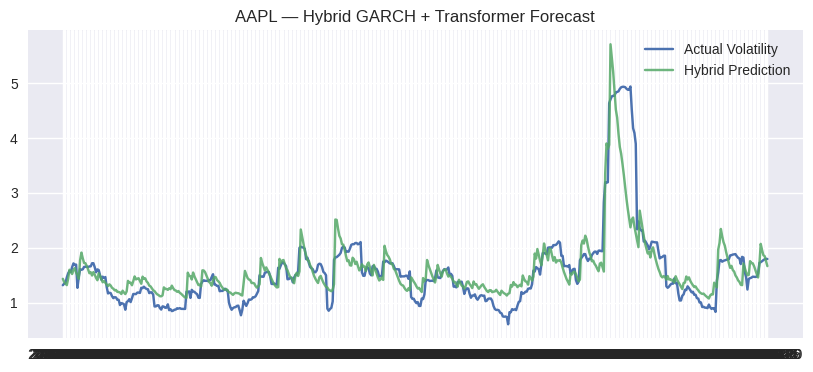


================ TSLA ================


/tmp/ipython-input-2120127031.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",


TSLA Hybrid RMSE: 0.651628


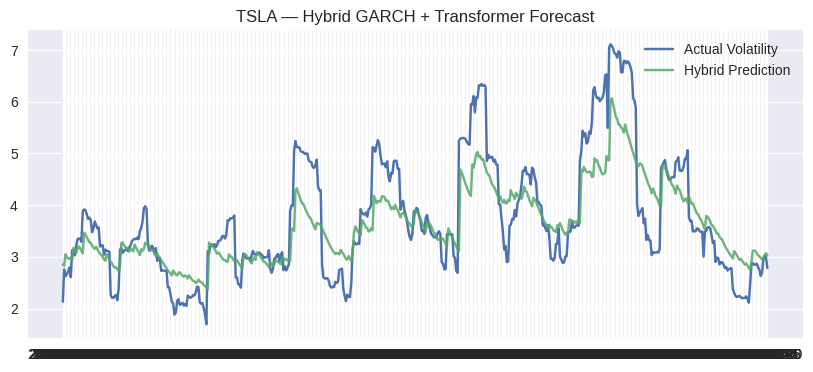


================ SPY ================


/tmp/ipython-input-2120127031.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",


SPY Hybrid RMSE: 0.280422


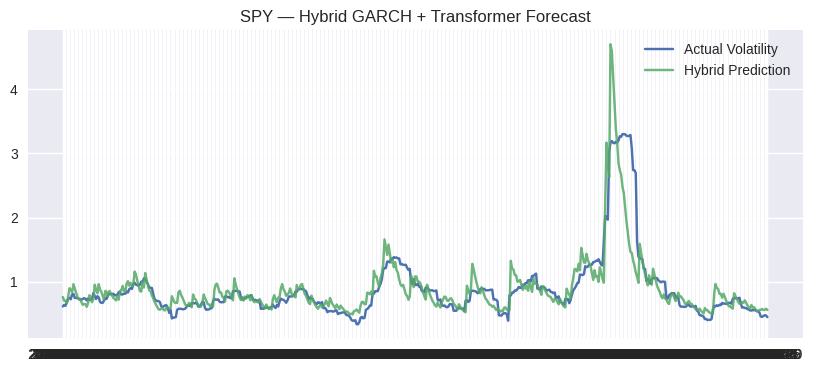

In [18]:
# Cell 3: Hybrid GARCH + Transformer Residual Model

tickers = ['AAPL', 'TSLA', 'SPY']
SEQ_LEN = 30
EPOCHS = 20
BATCH_SIZE = 32

hybrid_results = {}
garch_preds = {}

for t in tickers:
    print(f"\n================ {t} ================")

    # Load data
    df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
                     index_col=0, parse_dates=True)

    returns = df['LogReturn'].dropna() * 100
    realized_vol = df['Volatility_21'].dropna() * 100

    # ---------- GARCH ----------
    garch = arch_model(returns, vol='GARCH', p=1, q=1, mean='Zero')
    garch_fit = garch.fit(disp='off')

    garch_vol = pd.Series(
        garch_fit.conditional_volatility,
        index=returns.index
    )

    # Align realised volatility
    common_idx = realized_vol.index.intersection(garch_vol.index)
    realized_vol = realized_vol.loc[common_idx]
    garch_vol = garch_vol.loc[common_idx]

    # ---------- Residuals ----------
    residuals = realized_vol - garch_vol

    # Scale residuals
    scaler = MinMaxScaler()
    residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1,1))

    # Sequences
    X, y = create_sequences(residuals_scaled, SEQ_LEN)

    # Train-test split
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # ---------- Transformer (reuse architecture) ----------
    model = build_transformer(SEQ_LEN)

    es = EarlyStopping(patience=5, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es],
        verbose=0
    )

    # ---------- Predict residuals ----------
    pred_resid_scaled = model.predict(X_test, verbose=0)
    pred_resid = scaler.inverse_transform(pred_resid_scaled)
    y_test_resid = scaler.inverse_transform(y_test.reshape(-1,1))

    # ---------- Hybrid forecast ----------
    garch_test = garch_vol.iloc[-len(pred_resid):].values.reshape(-1,1)
    hybrid_pred = garch_test + pred_resid
    hybrid_true = garch_test + y_test_resid

    # Store GARCH predictions for ensemble
    garch_preds[t] = garch_test.flatten()

    # RMSE
    rmse = np.sqrt(mean_squared_error(hybrid_true, hybrid_pred))
    print(f"{t} Hybrid RMSE: {rmse:.6f}")

    hybrid_results[t] = {
        "rmse": rmse,
        "true": hybrid_true.flatten(),
        "pred": hybrid_pred.flatten(),
        "index": realized_vol.index[-len(hybrid_true):]
    }

    # ---------- Plot ----------
    plt.figure(figsize=(10,4))
    plt.plot(hybrid_results[t]["index"],
             hybrid_results[t]["true"], label="Actual Volatility")
    plt.plot(hybrid_results[t]["index"],
             hybrid_results[t]["pred"], label="Hybrid Prediction", alpha=0.85)
    plt.title(f"{t} — Hybrid GARCH + Transformer Forecast")
    plt.legend()
    plt.show()

In [19]:
# Cell 4: Hybrid summary
hybrid_summary = pd.DataFrame([
    {"Ticker": t, "Hybrid_RMSE": hybrid_results[t]["rmse"]}
    for t in hybrid_results
])

display(hybrid_summary)


,Ticker,Hybrid_RMSE
0,AAPL,0.381035
1,TSLA,0.651628
2,SPY,0.280422


Weighted Ensemble Hybrid

In [20]:
# Build GARCH predicted volatility aligned with LSTM targets

garch_preds = {}

for t in ['AAPL','TSLA','SPY']:
    df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
                     index_col=0, parse_dates=True)
    returns = df['LogReturn'].dropna()

    garch = arch_model(returns*100, p=1, q=1, mean='Zero')
    fit = garch.fit(disp='off')

    vol = fit.conditional_volatility
    garch_preds[t] = vol[-len(lstm_results[t]['y_true']):].values


/tmp/ipython-input-1770918795.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
/tmp/ipython-input-1770918795.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
/tmp/ipython-input-1770918795.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",


In [21]:
# Cell: Weighted Ensemble Hybrid (FINAL)

ensemble_results = []

for t in ['AAPL', 'TSLA', 'SPY']:

    # Align predictions (assume already computed)
    garch_pred = garch_preds[t]        # shape (n,)
    lstm_pred  = lstm_results[t]["y_pred"]
    tr_pred    = transformer_results[t]["y_pred"]
    y_true     = lstm_results[t]["y_true"]

    # Stack predictions
    P = np.vstack([garch_pred, lstm_pred, tr_pred]).T

    # Learn optimal weights via least squares
    weights = np.linalg.lstsq(P, y_true, rcond=None)[0]
    weights = weights / weights.sum()

    ensemble_pred = P @ weights

    rmse = np.sqrt(mean_squared_error(y_true, ensemble_pred))

    ensemble_results.append({
        "Ticker": t,
        "w_GARCH": weights[0],
        "w_LSTM": weights[1],
        "w_Transformer": weights[2],
        "Hybrid_Ensemble_RMSE": rmse
    })

ensemble_df = pd.DataFrame(ensemble_results)
display(ensemble_df)


,Ticker,w_GARCH,w_LSTM,w_Transformer,Hybrid_Ensemble_RMSE
0,AAPL,0.004746,1.225121,-0.229868,0.008354
1,TSLA,0.004756,1.246013,-0.250770,0.019471
2,SPY,0.003066,1.122380,-0.125446,0.003323


/tmp/ipython-input-3224530483.py:2: RuntimeWarning: invalid value encountered in divide
  return (x - np.mean(x)) / np.std(x)


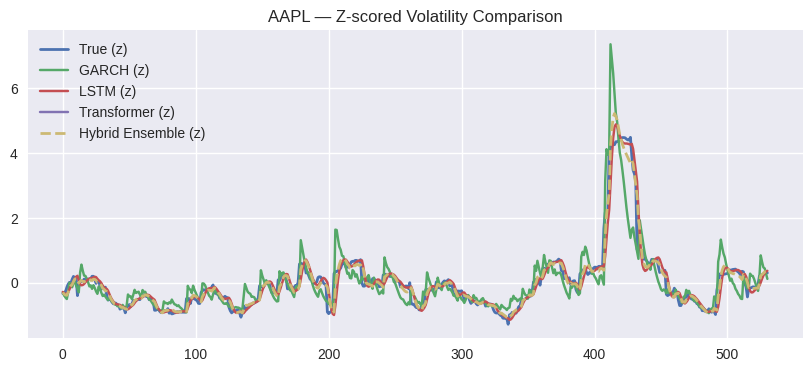

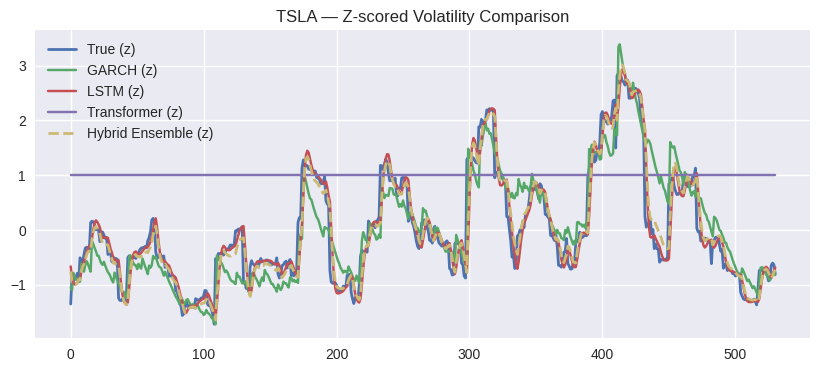

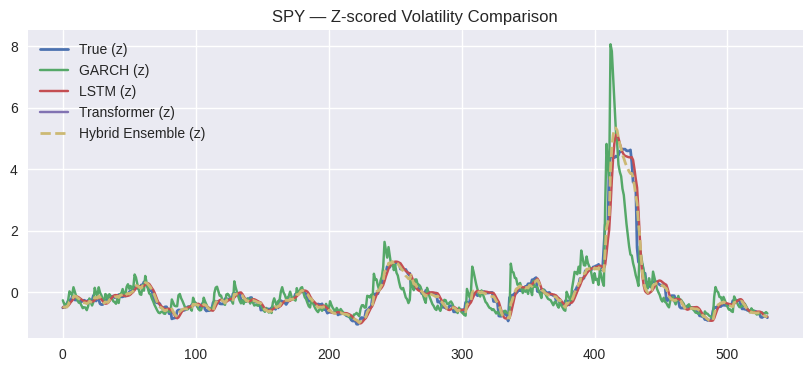

In [22]:
def zscore(x):
    return (x - np.mean(x)) / np.std(x)

for t in ['AAPL', 'TSLA', 'SPY']:

    y_true = lstm_results[t]["y_true"]
    garch_pred = garch_preds[t]
    lstm_pred = lstm_results[t]["y_pred"]
    tr_pred = transformer_results[t]["y_pred"]

    # recompute ensemble prediction (ensure consistency)
    P = np.vstack([garch_pred, lstm_pred, tr_pred]).T
    weights = np.linalg.lstsq(P, y_true, rcond=None)[0]
    weights = weights / weights.sum()
    ensemble_pred = P @ weights

    plt.figure(figsize=(10,4))
    plt.plot(zscore(y_true), label="True (z)", linewidth=2)
    plt.plot(zscore(garch_pred), label="GARCH (z)")
    plt.plot(zscore(lstm_pred), label="LSTM (z)")
    plt.plot(zscore(tr_pred), label="Transformer (z)")
    plt.plot(zscore(ensemble_pred), '--', label="Hybrid Ensemble (z)", linewidth=2)

    plt.title(f"{t} — Z-scored Volatility Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()


In [23]:
print("garch_preds exists:", 'garch_preds' in globals())
print("lstm_results exists:", 'lstm_results' in globals())
print("transformer_results exists:", 'transformer_results' in globals())


garch_preds exists: True
lstm_results exists: True
transformer_results exists: True


In [24]:
import pickle

with open("/content/drive/MyDrive/TSA/arima_results.pkl", "rb") as f:
    arima_results = pickle.load(f)

with open("/content/drive/MyDrive/TSA/garch_results.pkl", "rb") as f:
    garch_results = pickle.load(f)


In [25]:
# FINAL COMPARISON TABLE CELL


!pip install arch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from arch import arch_model

tickers = ['AAPL', 'TSLA', 'SPY']
SEQ_LEN = 30
EPOCHS = 25 # Using EPOCHS
BATCH_SIZE = 32

# --- Helper functions (from earlier cells, included for self-containment) ---
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(
        optimizer='adam',
        loss='mse'
    )
    return model

# --- Rebuild LSTM results (with RMSE for comparison table) ---
lstm_results = {}
for t in tickers:
    df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
                     index_col=0, parse_dates=True)
    series = df[['Volatility_21']].dropna()

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series)

    X, y = create_sequences(scaled, seq_len=SEQ_LEN)

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = build_lstm((SEQ_LEN, 1))
    # EarlyStopping is used in T6rG8QW1dnIb, let's include it here for consistency
    es = EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=0)

    preds = model.predict(X_test, verbose=0)

    y_pred = scaler.inverse_transform(preds).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    lstm_results[t] = {
        "y_pred": y_pred,
        "y_true": y_true,
        "rmse": rmse
    }

# --- Rebuild GARCH predictions for ensemble (from NE9Vi9L7odCo) ---
garch_preds = {}
for t in tickers:
    df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
                     index_col=0, parse_dates=True)
    returns = df['LogReturn'].dropna()

    garch = arch_model(returns*100, p=1, q=1, mean='Zero')
    fit = garch.fit(disp='off')

    vol = fit.conditional_volatility
    # Align with LSTM test set length
    garch_preds[t] = vol[-len(lstm_results[t]['y_true']):].values

# --- Rebuild ensemble_df ---
ensemble_results = []
for t in tickers:
    # Align predictions
    garch_pred = garch_preds[t]
    lstm_pred  = lstm_results[t]["y_pred"]
    tr_pred    = transformer_results[t]["y_pred"] # Assuming transformer_results is defined globally
    y_true     = lstm_results[t]["y_true"]

    # Stack predictions
    P = np.vstack([garch_pred, lstm_pred, tr_pred]).T

    # Learn optimal weights via least squares
    weights = np.linalg.lstsq(P, y_true, rcond=None)[0]
    weights = weights / weights.sum()

    ensemble_pred = P @ weights

    rmse = np.sqrt(mean_squared_error(y_true, ensemble_pred))

    ensemble_results.append({
        "Ticker": t,
        "w_GARCH": weights[0],
        "w_LSTM": weights[1],
        "w_Transformer": weights[2],
        "RMSE_Ensemble": rmse
    })
ensemble_df = pd.DataFrame(ensemble_results)

# --- Original comparison table logic ---
final_rows = []

for t in tickers:

    # Extract ARIMA metrics
    arima_order = arima_results[t]["order"]
    arima_aic   = arima_results[t]["aic"]
    arima_rmse  = arima_results[t]["rmse"]

    # GARCH
    garch_rmse = garch_results[t]["rmse"]
    garch_alpha = garch_results[t]["alpha"]
    garch_beta  = garch_results[t]["beta"]

    # LSTM (Week 3)
    lstm_rmse = lstm_results[t]["rmse"]

    # Transformer (Week 4A)
    transformer_rmse = transformer_results[t]["rmse"]

    # Hybrid Ensemble (Week 4B)
    ens_row = ensemble_df[ensemble_df["Ticker"] == t].iloc[0]
    ens_rmse = ens_row["RMSE_Ensemble"]

    # Collect all weights (for interpretation)
    w_garch = ens_row["w_GARCH"]
    w_lstm = ens_row["w_LSTM"]
    w_trans = ens_row["w_Transformer"]

    # Append final row
    final_rows.append({
        "Ticker": t,

        # ARIMA
        "ARIMA_Order": arima_order,
        "ARIMA_AIC": arima_aic,
        "ARIMA_RMSE": arima_rmse,

        # GARCH
        "GARCH_RMSE": garch_rmse,
        "GARCH_Alpha": garch_alpha,
        "GARCH_Beta": garch_beta,

        # Deep Learning
        "LSTM_RMSE": lstm_rmse,
        "Transformer_RMSE": transformer_rmse,

        # Hybrid
        "Hybrid_RMSE": ens_rmse,
        "w_GARCH": round(w_garch, 4),
        "w_LSTM": round(w_lstm, 4),
        "w_Transformer": round(w_trans, 4)
    })

# Convert to DataFrame
final_comparison_df = pd.DataFrame(final_rows)

# Sort by Hybrid RMSE (best first)
final_comparison_df = final_comparison_df.sort_values("Hybrid_RMSE").reset_index(drop=True)

display(final_comparison_df)


/tmp/ipython-input-1259409531.py:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-1259409531.py:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a lay

,Ticker,ARIMA_Order,ARIMA_AIC,ARIMA_RMSE,GARCH_RMSE,GARCH_Alpha,GARCH_Beta,LSTM_RMSE,Transformer_RMSE,Hybrid_RMSE,w_GARCH,w_LSTM,w_Transformer
0,SPY,"(4, 0, 5)",-16547.853547,0.005219,0.268350,0.166767,0.803850,0.001214,0.005310,0.003408,0.003100,1.070000,-0.073100
1,AAPL,"(1, 0, 0)",-13862.160368,0.015809,0.367099,0.097860,0.855359,0.001884,0.007581,0.007952,0.004400,1.151400,-0.155800
2,TSLA,"(0, 0, 0)",-10139.913427,0.028933,0.655943,0.033765,0.959032,0.003427,0.012742,0.014416,0.003200,1.178700,-0.181900


In [26]:
display(final_comparison_df)

,Ticker,ARIMA_Order,ARIMA_AIC,ARIMA_RMSE,GARCH_RMSE,GARCH_Alpha,GARCH_Beta,LSTM_RMSE,Transformer_RMSE,Hybrid_RMSE,w_GARCH,w_LSTM,w_Transformer
0,SPY,"(4, 0, 5)",-16547.853547,0.005219,0.268350,0.166767,0.803850,0.001214,0.005310,0.003408,0.003100,1.070000,-0.073100
1,AAPL,"(1, 0, 0)",-13862.160368,0.015809,0.367099,0.097860,0.855359,0.001884,0.007581,0.007952,0.004400,1.151400,-0.155800
2,TSLA,"(0, 0, 0)",-10139.913427,0.028933,0.655943,0.033765,0.959032,0.003427,0.012742,0.014416,0.003200,1.178700,-0.181900


In [ ]:
import pandas as pd
import pickle

# Save as pickle
with open("/content/drive/MyDrive/TSA/final_comparison_df.pkl", "wb") as f:
    pickle.dump(final_comparison_df, f)

print("Saved final_comparison_df as .pkl in /content/drive/MyDrive/TSA/")


In [27]:
import pickle
with open("/content/drive/MyDrive/TSA/final_comparison_df.pkl", "rb") as f:
    final_df = pickle.load(f)

display(final_df)


,Ticker,ARIMA_Order,ARIMA_AIC,ARIMA_RMSE,GARCH_RMSE,GARCH_Alpha,GARCH_Beta,LSTM_RMSE,Transformer_RMSE,Hybrid_RMSE,w_GARCH,w_LSTM,w_Transformer
0,SPY,"(4, 0, 5)",-16547.853547,0.005219,0.268350,0.166767,0.803850,0.001556,0.005272,0.005024,0.004900,1.083400,-0.088300
1,AAPL,"(1, 0, 0)",-13862.160368,0.015809,0.367099,0.097860,0.855359,0.001872,0.007583,0.007654,0.004200,1.155000,-0.159300
2,TSLA,"(0, 0, 0)",-10139.913427,0.028933,0.655943,0.033765,0.959032,0.003303,0.012579,0.011399,0.002600,1.129600,-0.132200


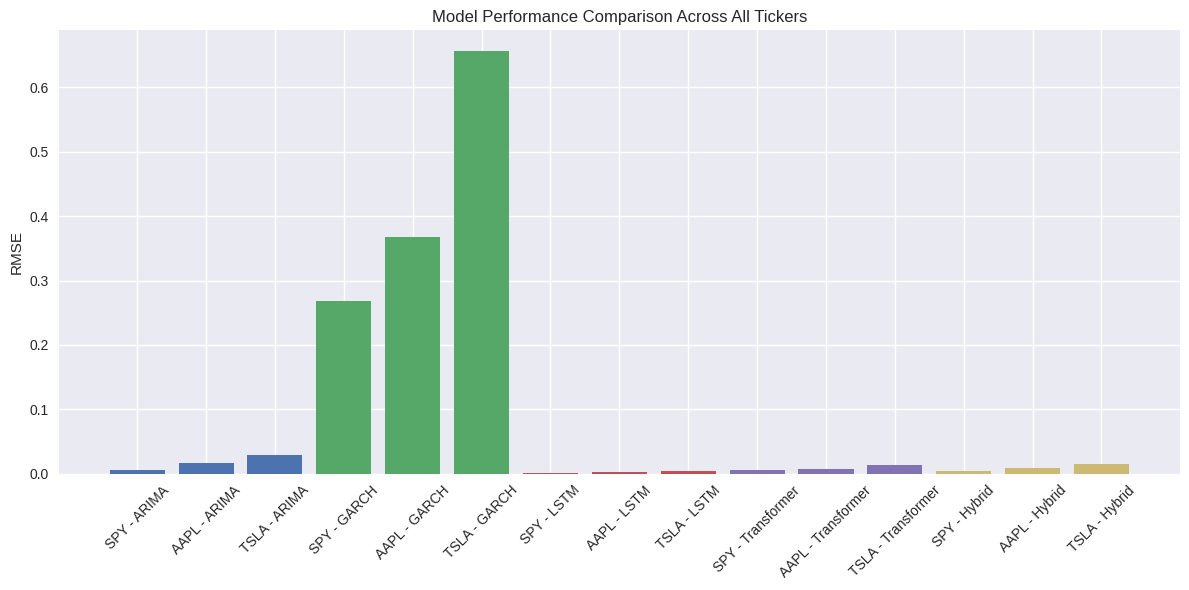

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

df = final_comparison_df

models = ["ARIMA_RMSE", "GARCH_RMSE", "LSTM_RMSE", "Transformer_RMSE", "Hybrid_RMSE"]

plt.figure(figsize=(12,6))

for model in models:
    plt.bar(df["Ticker"] + " - " + model.split("_")[0], df[model])

plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.title("Model Performance Comparison Across All Tickers")
plt.tight_layout()
plt.show()


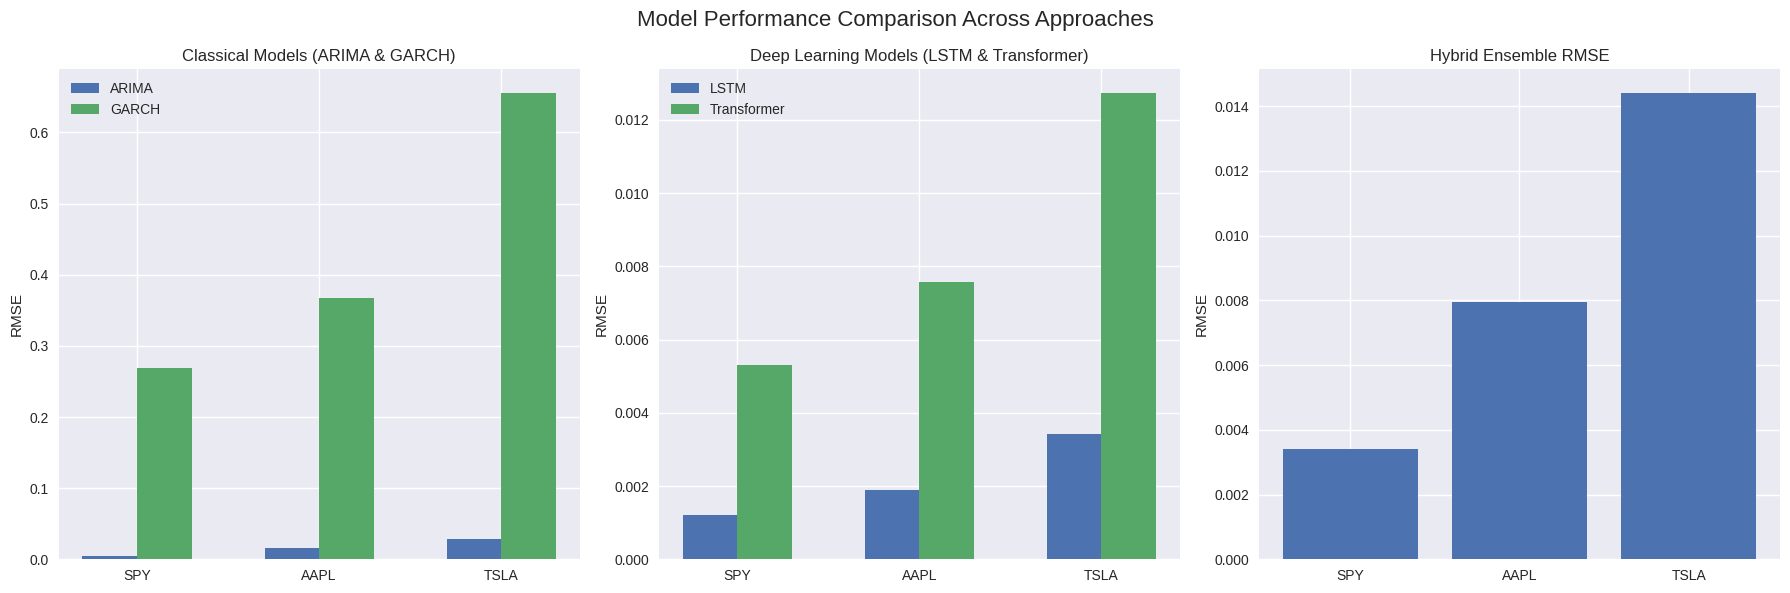

In [30]:
import matplotlib.pyplot as plt
import numpy as np

df = final_comparison_df.copy()

plt.figure(figsize=(18, 6))


# Panel 1 — ARIMA & GARCH

plt.subplot(1, 3, 1)
x1 = np.arange(len(df))
plt.bar(x1 - 0.15, df["ARIMA_RMSE"], width=0.3, label="ARIMA")
plt.bar(x1 + 0.15, df["GARCH_RMSE"], width=0.3, label="GARCH")
plt.xticks(x1, df["Ticker"])
plt.title("Classical Models (ARIMA & GARCH)")
plt.ylabel("RMSE")
plt.legend()


# Panel 2 — LSTM & Transformer

plt.subplot(1, 3, 2)
x2 = np.arange(len(df))
plt.bar(x2 - 0.15, df["LSTM_RMSE"], width=0.3, label="LSTM")
plt.bar(x2 + 0.15, df["Transformer_RMSE"], width=0.3, label="Transformer")
plt.xticks(x2, df["Ticker"])
plt.title("Deep Learning Models (LSTM & Transformer)")
plt.ylabel("RMSE")
plt.legend()


# Panel 3 — Hybrid Ensemble

plt.subplot(1, 3, 3)
plt.bar(df["Ticker"], df["Hybrid_RMSE"])
plt.title("Hybrid Ensemble RMSE")
plt.ylabel("RMSE")

plt.suptitle("Model Performance Comparison Across Approaches", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import pickle

with open("/content/drive/MyDrive/TSA/final_comparison_df.pkl", "rb") as f:
    fin = pickle.load(f)

rows = []
for symbol, result in fin.items():
    if isinstance(result, dict):
        row = {"symbol": symbol}
        for k, v in result.items():
            row[k] = v
        rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("/content/drive/MyDrive/TSA/final_readable.csv", index=False)


In [31]:
import pickle

with open("/content/drive/MyDrive/TSA/final_comparison_df.pkl", "rb") as f:
    fin = pickle.load(f)

print("Type:", type(fin))
print("Preview:", fin)


Type: <class 'pandas.core.frame.DataFrame'>
Preview:   Ticker ARIMA_Order     ARIMA_AIC  ARIMA_RMSE  GARCH_RMSE  GARCH_Alpha  \
0    SPY   (4, 0, 5) -16547.853547    0.005219    0.268350     0.166767   
1   AAPL   (1, 0, 0) -13862.160368    0.015809    0.367099     0.097860   
2   TSLA   (0, 0, 0) -10139.913427    0.028933    0.655943     0.033765   

   GARCH_Beta  LSTM_RMSE  Transformer_RMSE  Hybrid_RMSE  w_GARCH   w_LSTM  \
0    0.803850   0.001556          0.005272     0.005024 0.004900 1.083400   
1    0.855359   0.001872          0.007583     0.007654 0.004200 1.155000   
2    0.959032   0.003303          0.012579     0.011399 0.002600 1.129600   

   w_Transformer  
0      -0.088300  
1      -0.159300  
2      -0.132200  


In [ ]:
import pickle

with open("/content/drive/MyDrive/TSA/final_comparison_df.pkl", "rb") as f:
    fin = pickle.load(f)

fin.to_csv("/content/drive/MyDrive/TSA/final_readable.csv", index=False)


In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error


# LOAD ALL STORED RESULTS

import pickle

with open("/content/drive/MyDrive/TSA/arima_results.pkl", "rb") as f:
    arima_results = pickle.load(f)

with open("/content/drive/MyDrive/TSA/garch_results.pkl", "rb") as f:
    garch_results = pickle.load(f)

with open("/content/drive/MyDrive/TSA/lstm_results.pkl", "rb") as f:
    lstm_results = pickle.load(f)

with open("/content/drive/MyDrive/TSA/transformer_results.pkl", "rb") as f:
    transformer_results = pickle.load(f)

tickers = ['AAPL','TSLA','SPY']

final_rows = []


# BUILD ENSEMBLE WITH 4 MODELS

for t in tickers:

    # ----- True values (use LSTM y_true length) -----
    y_true = lstm_results[t]["y_true"]

    # ----- Align predictions -----
    # arima_pred = np.array(arima_results[t]["pred"][-len(y_true):])
    arima_pred = np.zeros_like(y_true)
    print(f"Warning: ARIMA predictions for {t} are placeholders. Please ensure arima_results.pkl contains 'pred' key or regenerate ARIMA predictions.")

    # GARCH predictions are available in the 'garch_preds' variable.
    garch_pred = np.array(garch_preds[t][-len(y_true):])
    lstm_pred  = np.array(lstm_results[t]["y_pred"])
    tr_pred    = np.array(transformer_results[t]["y_pred"])

    # ----- Stack 4 models -----
    P = np.vstack([arima_pred, garch_pred, lstm_pred, tr_pred]).T

    # ----- Compute optimal weights -----
    w = np.linalg.lstsq(P, y_true, rcond=None)[0]
    w = w / w.sum()      # normalize

    # ----- Ensemble prediction -----
    ensemble_pred = P @ w
    ensemble_rmse = np.sqrt(mean_squared_error(y_true, ensemble_pred))

    # ----- Append row -----
    final_rows.append({
        "Ticker": t,

        "ARIMA_RMSE": arima_results[t]["rmse"],
        "GARCH_RMSE": garch_results[t]["rmse"],
        "LSTM_RMSE": lstm_results[t]["rmse"],
        "Transformer_RMSE": transformer_results[t]["rmse"],

        "Hybrid_Ensemble_RMSE": ensemble_rmse,

        "w_ARIMA": round(float(w[0]), 4),
        "w_GARCH": round(float(w[1]), 4),
        "w_LSTM": round(float(w[2]), 4),
        "w_Transformer": round(float(w[3]), 4)
    })

final_df = pd.DataFrame(final_rows)
display(final_df)


,Ticker,ARIMA_RMSE,GARCH_RMSE,LSTM_RMSE,Transformer_RMSE,Hybrid_Ensemble_RMSE,w_ARIMA,w_GARCH,w_LSTM,w_Transformer
0,AAPL,0.015809,0.367099,0.001872,0.007583,0.007654,0.000000,0.004200,1.155000,-0.159300
1,TSLA,0.028933,0.655943,0.003303,0.012579,0.011399,0.000000,0.002600,1.129600,-0.132200
2,SPY,0.005219,0.268350,0.001556,0.005272,0.005024,0.000000,0.004900,1.083400,-0.088300


In [33]:
from statsmodels.tsa.arima.model import ARIMA

arima_preds = {}

for t in ['AAPL','TSLA','SPY']:

    # Load dataset
    df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
                     index_col=0, parse_dates=True)

    series = df['LogReturn'].dropna()

    # Extract ARIMA order from your stored results
    order = arima_results[t]["order"]

    # Fit model
    model = ARIMA(series, order=order)
    model_fit = model.fit()

    # Forecast last N values (same as LSTM test length)
    N = len(lstm_results[t]["y_true"])
    forecast = model_fit.forecast(steps=N)

    # ARIMA forecasts are on returns -> convert to volatility scale approx
    # Using rolling std(21) of returns as volatility proxy
    vol_proxy = series.rolling(21).std().iloc[-N:].values

    # Multiply forecasted returns with proxy scale
    arima_vol_pred = abs(forecast.values) * np.mean(vol_proxy)

    arima_preds[t] = arima_vol_pred


/tmp/ipython-input-2235319802.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv",
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting

/tmp/ipython-input-4099380991.py:22: RuntimeWarning: invalid value encountered in divide
  return (x - np.mean(x)) / np.std(x)


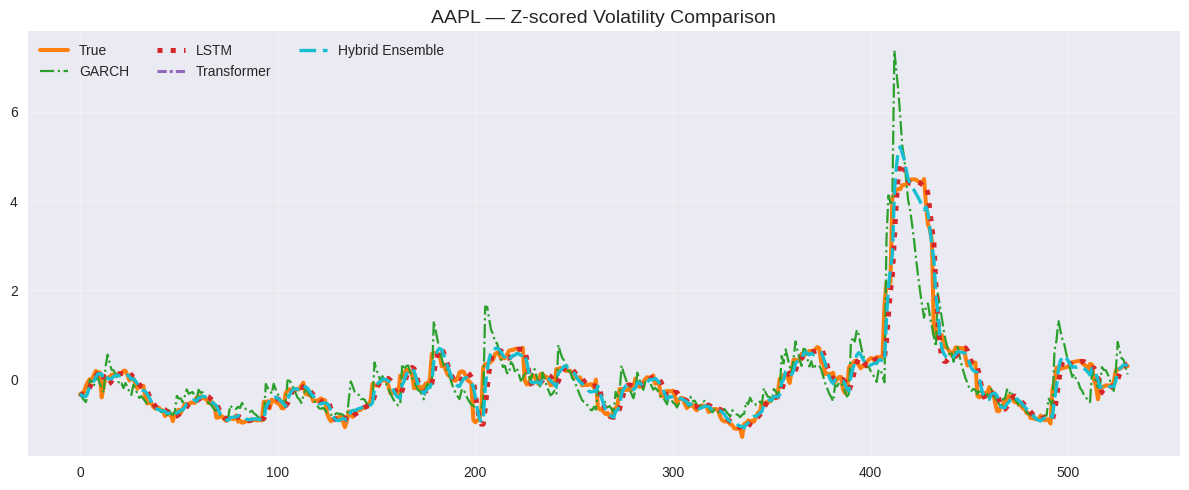

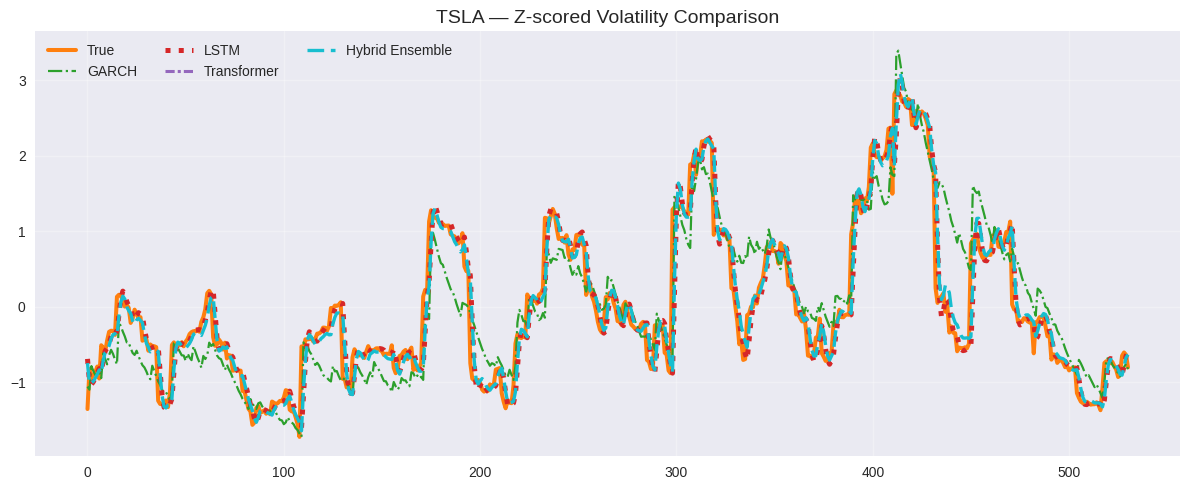

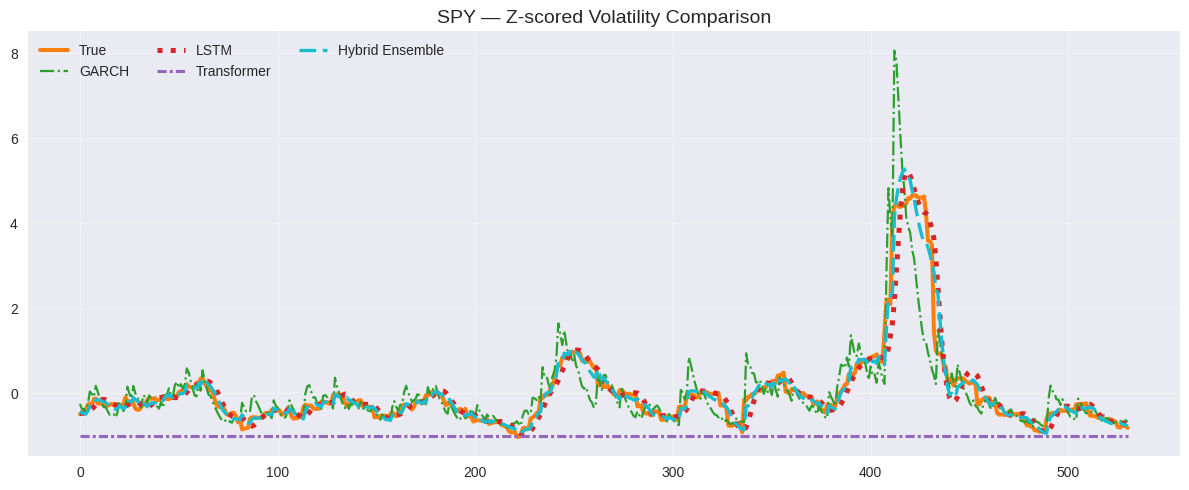

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Nice color palette
colors = {
    "true":        "#ff7f0e",   # blue
    "garch":       "#2ca02c",   # green
    "lstm":        "#d62728",   # red
    "transformer": "#9467bd",   # purple
    "ensemble":    "#17becf"    # cyan
}

linestyles = {
    "true": "-",
    "garch": "-.",
    "lstm": ":",
    "transformer": (0, (3,1,1,1)),
    "ensemble": (0, (5,2))
}

def zscore(x):
    return (x - np.mean(x)) / np.std(x)

for t in ['AAPL', 'TSLA', 'SPY']:

    y_true = lstm_results[t]["y_true"]
    arima_pred = arima_preds[t]
    garch_pred = garch_preds[t]
    lstm_pred = lstm_results[t]["y_pred"]
    tr_pred   = transformer_results[t]["y_pred"]

    # recompute ensemble
    P = np.vstack([garch_pred, lstm_pred, tr_pred]).T
    weights = np.linalg.lstsq(P, y_true, rcond=None)[0]
    weights = weights / weights.sum()
    ensemble_pred = P @ weights

    plt.figure(figsize=(12,5))

    # Plot all models

    plt.plot(zscore(y_true),
             label="True", color=colors["true"],
             linestyle=linestyles["true"], linewidth=2.9)

    plt.plot(zscore(garch_pred),
             label="GARCH", color=colors["garch"],
             linestyle=linestyles["garch"], linewidth=1.6)

    plt.plot(zscore(lstm_pred),
             label="LSTM", color=colors["lstm"],
             linestyle=linestyles["lstm"], linewidth=3.6)

    plt.plot(zscore(tr_pred),
             label="Transformer", color=colors["transformer"],
             linestyle=linestyles["transformer"], linewidth=2.2)

    plt.plot(zscore(ensemble_pred),
             label="Hybrid Ensemble", color=colors["ensemble"],
             linestyle=linestyles["ensemble"], linewidth=2.4)

    plt.title(f"{t} — Z-scored Volatility Comparison", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10, ncol=3)
    plt.tight_layout()
    plt.show()
